In [13]:
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from scipy.linalg import eigh
from sklearn.svm import SVC as svc
from matplotlib.colors import ListedColormap
from mlxtend.plotting import plot_decision_regions
data =Path('data')

In [6]:
sample_img = 'data/subject01.centerlight'

In [7]:
test = {}
train = {}
subject_data = {}
for file_name in data.glob('subject*'):
    subject_data[file_name.stem] = subject_data.get(file_name.stem,[]) + [file_name]
    
for key,value in subject_data.items():
    test[key] = value[-2:]
    train[key] = value[:-2]
    
h = 243
w = 320
img_size  = (h,w)
N = 3
small_img_size = (h//N,w//N)

In [32]:
def create_dataset(ids):
    '''
    Pass the subject ids as argument list.
    Default train test split is to chose 9 pictures for train and 2 pictures for test.
    Returns x_train,y_train,x_test,y_test
    '''
    x_train = [(cv2.resize(plt.imread(img),(w//N,h//N)).reshape(-1,1),id_) for id_ in ids for img in train[id_]]
    y_train = [id_ for id_ in ids for img in train[id_]]
    x_test =  [(cv2.resize(plt.imread(img),(w//N,h//N)).reshape(-1,1),id_) for id_ in ids for img in  test[id_]]
    y_test = [id_ for id_ in ids for img in test[id_]]

    x_train_array = np.empty((x_train[0][0].shape[0],len(x_train)))

    for i,(x,y) in enumerate(x_train):
        x_train_array[:,i]  = x.squeeze()


    x_test_array = np.empty((x_test[0][0].shape[0],len(x_test)))
    for i,(x,y) in enumerate(x_test):
        x_test_array[:,i]  = x.squeeze()
    
    return x_train_array, y_train,x_test_array,y_test

def ids_to_int(ids):
    return np.array([int(id_[-2:]) for id_ in ids])


In [14]:
ids = ['subject01','subject02','subject03','subject04']
x_train,y_train,x_test,y_test = create_dataset(ids)
mu = np.mean(x_train,axis=1,keepdims=True)
S_t = np.dot((x_train-mu),(x_train-mu).T)

e,v = eigh(S_t)
highest_e_args = np.argsort(-e)

e = e[highest_e_args]
v = v[highest_e_args]

print(f'highest eigen values are {e[:2]} and corresponding vectors {v[:2]}')

highest eigen values are [3.47464932e+08 2.10129669e+08] and corresponding vectors [[ 0.00319168 -0.00221664  0.00895874 ...  0.00637485 -0.01190682
  -0.00861062]
 [-0.00245052 -0.00347688  0.00945602 ...  0.00896718 -0.01066136
  -0.00791854]]


/tmp/ipykernel_17892/2689870061.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


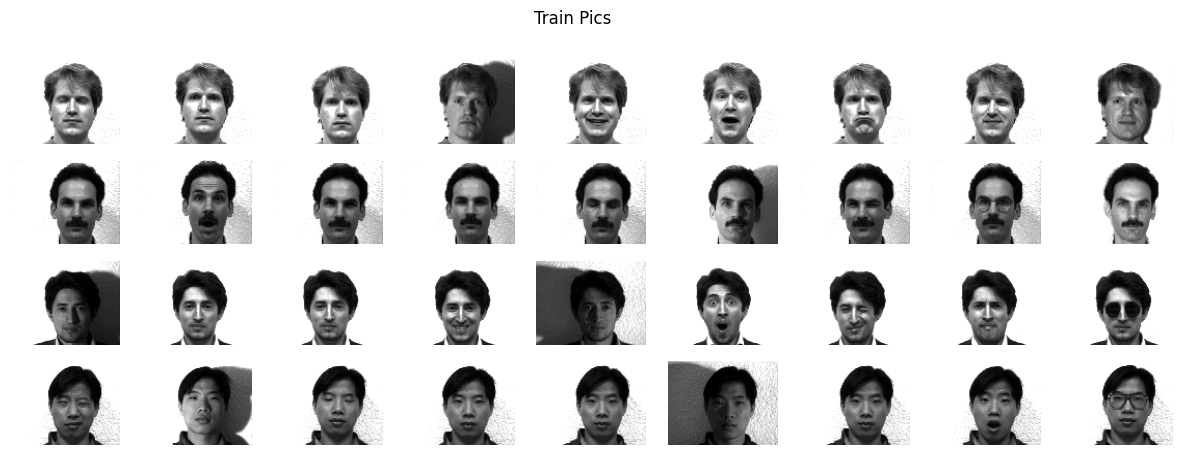

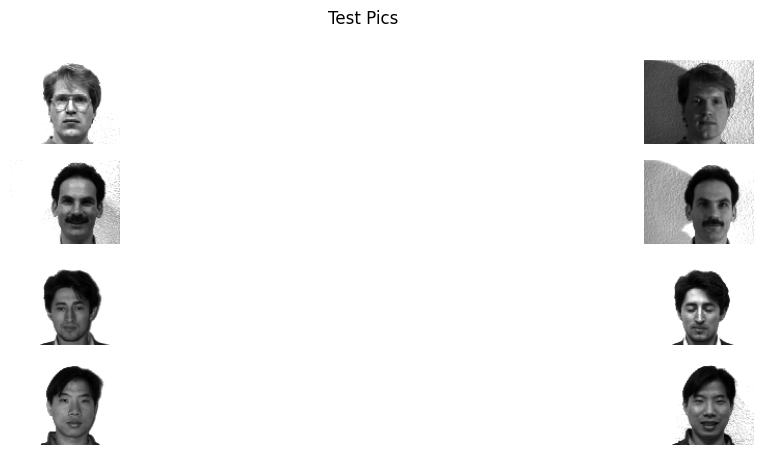

In [68]:
def plot_figs(ncols,x,title):
    fig = plt.figure(figsize=(15,5))
    for i in range(x.shape[1]):
        ax = fig.add_subplot(len(ids),ncols,i+1)
        ax.imshow(x[:,i].reshape(small_img_size),cmap='gray')
        ax.axis('off')
    fig.suptitle(title)
    fig.show()

    
plot_figs(9,x_train,'Train Pics')
plot_figs(2,x_test,'Test Pics')

In [88]:
def transform_to_ND(v,components,X):
    W = v[:,components]
    return np.dot(W.T,X).T


x_train_2d = transform_to_ND(v,[2,3],x_train)
x_test_2d = transform_to_ND(v,[2,3],x_test)
    

In [89]:
x_train_2d.shape

(36, 2)

In [90]:
svm = svc(max_iter=10000000)
svm.fit(x_train_2d,ids_to_int(y_train))

SVC(max_iter=10000000)

/home/ubuntu/IITD/PhD/ELL784/fisher/Asg2/venv/lib/python3.8/site-packages/mlxtend/plotting/decision_regions.py:300: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


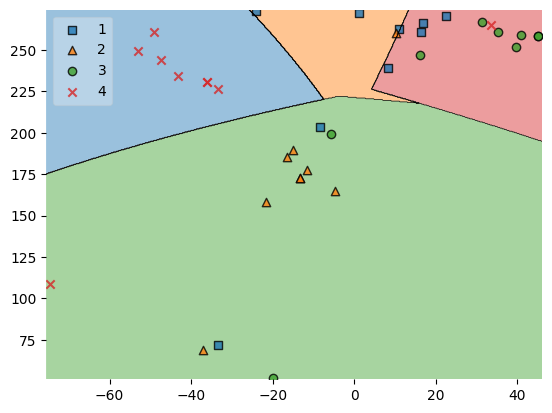

In [91]:
plot_decision_regions(x_train_2d,ids_to_int(y_train), clf=svm, legend=2)
#plot_decision_regions(x_test_2d.T,ids_to_int(y_test), clf=svm, legend=2)

plt.show()

In [27]:
x = np.arange(-160,25,1)
y = []
for i,subject in enumerate(ids):
    y.append(-(svm.coef_[i][0]*x + svm.intercept_[i])/svm.coef_[i][1])
    

AttributeError: coef_ is only available when using a linear kernel

In [34]:
svm.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': 10000000,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

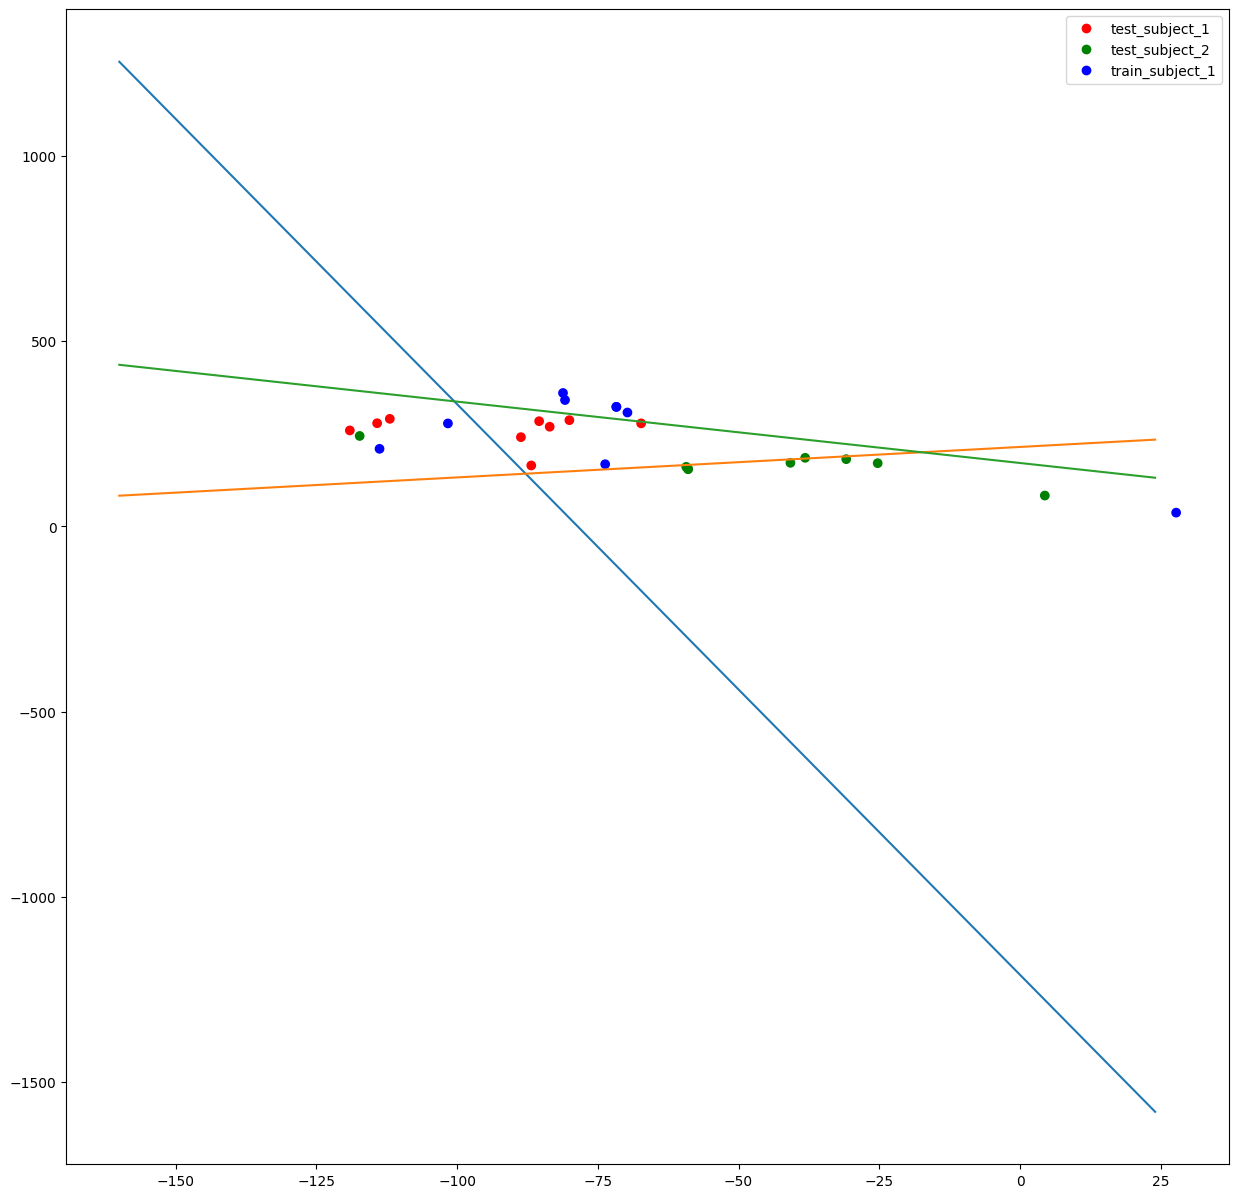

In [23]:
plt.figure(figsize=(15,15))
colors = ListedColormap(["red","green","blue"])

le1 = []
#scatter = plt.scatter(x_pca_test.T[:,0],x_pca_test.T[:,1] ,cmap=colors,c= [0]*2 + [1]*2 +[2]*2,marker = 'x')
#le1 = scatter.legend_elements()[0]
scatter = plt.scatter(x_pca_train.T[:,0],x_pca_train.T[:,1] ,cmap = colors,c=[0]*9+[1]*9+[2]*9)
le2 = scatter.legend_elements()[0]
plt.legend(handles=le1+le2, labels=['test_subject_1','test_subject_2','train_subject_1','train_subject_2'])

# Plotting lines
for i,yy in enumerate(y):
    plt.plot(x,yy,label=f'decision_boundary_{i}')
plt.show()

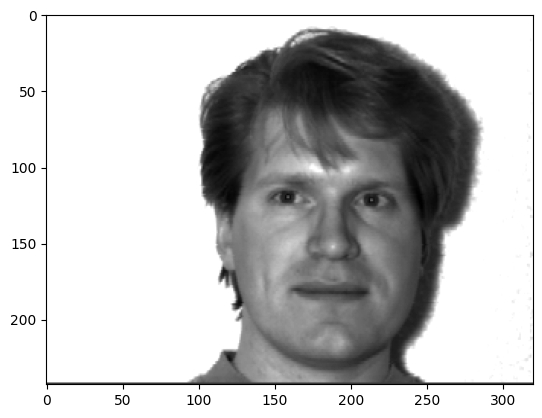

In [7]:
img = plt.imread('data/subject01.centerlight',format='gif')
plt.imshow(img,cmap='gray')